# Notebook to plot Y chromosome diversity over time

In [6]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time


# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

from python.plot_pca import *  # Import functions needed for the PCA plotting
from hapsburg.PackagesSupport.sqrt_scale import SquareRootScale

compute-e-16-229.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [144]:
df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v56.3.anno.haplogroups.csv") # Load Meta Data

min_snp = 100000 # Min SNP coverage for Y Call
age = [0,12000]
lat = [20,90]
lon = [-28, 180]
flag = ["_contam", "_dup"]

df_meta["study"]=df_meta["study"].fillna("missing") # Add Nan
idx = df_meta["n_cov_snp"]>min_snp
df=df_meta[idx].reset_index(drop=True)
print(f"Filtering to {np.sum(idx)}/{len(idx)} indiviuals with >{min_snp} SNPs.")
df["include"]=df["include_alt"].astype("int")

### Filtering based on Age
min_age=age[0]
idx = df["age"]>min_age
df=df[idx].reset_index(drop=True)
print(f"Filtering to {np.sum(idx)}/{len(idx)} inds >{min_age} BP.")

max_age = age[1]
idx = df["age"]<max_age
df = df[idx].reset_index(drop=True)
print(f"Filtering to {np.sum(idx)}/{len(idx)} inds <{max_age} BP.")

### Geographic Filtering
if (len(lat)>0) | (len(lon)>0):
    idx_lat = (lat[0] < df["lat"]) & (df["lat"] < lat[1])
    idx_lon = (lon[0] < df["lon"]) & (df["lon"] < lon[1])
    idx = (idx_lat & idx_lon)
    df=df[idx].reset_index(drop=True)
    print(f"Kept {np.sum(idx)}/{len(idx)} inds with matching lat/lon.")

### Flag tricky Indivdiuals
idx = df["clst"].str.contains("|".join(flag))
print(f"Kept {np.sum(~idx)}/{len(idx)} inds with good cluster labels.")
df=df[~idx].reset_index(drop=True)
df = df.sort_values(by="avg_cov_snp", ascending=False)
idx = df["Master ID"].duplicated()
print(f"Kept {np.sum(~idx)}/{len(idx)} unique Master IDs.")
df=df[~idx].reset_index(drop=True)

### Extract Males
idx= df["sex"]=="M"
print(f"Kept {np.sum(idx)}/{len(idx)} Males.")
df=df[idx].reset_index(drop=True)

### Flag Punic Individuals
df1 = pd.read_csv("./data/cluster_assignments_punic.v54.1i.tsv", sep="\t")
print(f"Extracted IIDs of {len(df1)} IIDs in Punic Project")
df_punic = pd.merge(df, df1, on="iid")
print(f"Merged to {len(df_punic)} Punic Males")

### Remove Romans
label_inc = ["Punic_Early", "Punic_Late", "Punic_Late2"]
df_punic = df_punic[df_punic["label"].isin(label_inc)]

#df_punic = df_punic[~df_punic["label"].str.contains("Roman")]
print(f"Filtered to {len(df_punic)} Punic Samples based on label")

### Remove Punics from generat Meta
df = df[~df["iid"].isin(df1["iid"])]
print(f"Filtered general Y to {len(df)} ancient, non Punic individuals")

### Go to published indivduals only
df =df[~df["study"].str.contains("Unpublished")]
print(f"Filtered to {len(df)} published ancient males")

Filtering to 29227/35545 indiviuals with >100000 SNPs.
Filtering to 22574/29227 inds >0 BP.
Filtering to 22448/22574 inds <12000 BP.
Kept 17910/22448 inds with matching lat/lon.
Kept 17707/17910 inds with good cluster labels.
Kept 16715/17707 unique Master IDs.
Kept 9262/16715 Males.
Extracted IIDs of 160 IIDs in Punic Project
Merged to 68 Punic Males
Filtered to 58 Punic Samples based on label
Filtered general Y to 9194 ancient, non Punic individuals
Filtered to 4059 published ancient males


In [96]:
df_punic[df_punic["loc"].str.contains("Tunis, Carthage")]["Y_haplo"]

45    E1b1b1a1b2a4b~
48     J2a1a1b2a1c2~
51        J1a2a1a2c1
53      E1b1b1b2a1a~
58      G2a2b2a1a1b2
60     J2a1a1a2b2a1a
62      J2b2a1a1a1b~
66           R1b1a1b
Name: Y_haplo, dtype: object

# 1) Code for Diversity Calculation

In [145]:
def filter_df_age(df, age_delta = 300, output=False):
    """Takes Dataframe as Input, and filters to samples within age_delta of median age.
    Return Dataframe and medium Age"""
    age_med = np.median(df["age"])
    idx = (df["age"]< age_med + age_delta) & (df["age"] > age_med - age_delta)
    df = df[idx].copy().reset_index(drop=False)
    if output:
        print(f"{np.sum(idx)}/{len(idx)} IIDs within {age_delta} y of median age {age_med}")
    return df, age_med

def get_y_counts(df, digits=3, col="Y_haplo"):
    """Get Y Chromosome counts from Dataframe df"""
    ys = df[col].str[:3]
    #print(ys)
    cts = ys.value_counts().values
    return cts

def simpson_di(x):
    """ Given a count vector, returns the Simpson Diversity Index
    """
    n = np.sum(x) # Sample Size
    h = np.sum(x*(x-1)) / (n*(n-1)) # Fraction of pairs are identiclal
    s = 1 - h 
    return 1-h

def create_ydiv_df(df, sites=[], col_loc="loc",
                   age_delta = 300, digits=3, min_m=5):
    """Take Meta Data as input, and for each site calculate
    the Simpson Index of Y chromosomes"""
    data = []
    
    for s in sites:
        df_t = df[df[col_loc]==s]
        
        ### Test Data Set
        df_t, age = filter_df_age(df_t, age_delta=age_delta)
        m = len(df_t)
        
        if m >= min_m: # Only run full analysis if enough males
            y = get_y_counts(df_t)
            D = simpson_di(y)

            data.append([s, age, m, D])
          
        else:
            continue

    df = pd.DataFrame(data)
    df.columns = ["loc", "age", "males", "D"]
    return df

def get_sub_df_region(df, region="", 
                      rec_col="region", loc_col="loc", min_n=5):
    """Get a Dataframe of Y haplogroup diversities per sites"""
    df_ib = df[df[rec_col].isin(region)]
    cts = df_ib[loc_col].value_counts()
    sites = cts[cts>=min_n].index.values
    df_y_it = create_ydiv_df(df, sites=sites)
    return df_y_it

def set_age_ydiv_df(df, site="", age=0,
                    site_col="loc", age_col="age"):
    """Set the Age of a Y Diversity Cluster"""
    idx = df[site_col]==site
    df.loc[idx, age_col]= age

def set_legends(ax, plots=[], legs=[], title="", loc="lower right"):
    """Set Legends in Panel Plots"""
    l1 = ax.legend(plots, legs, fontsize=11, loc=loc,
             title=title)
    
    l1.get_title().set_fontsize('13')
    l1.get_title().set_fontweight("bold")
    [lgd.set_color('white') for lgd in l1.legendHandles]
    [lgd.set_edgecolor('k') for lgd in l1.legendHandles]

In [146]:
df_y = create_ydiv_df(df_punic, sites=["Tunis, Carthage", "Sardinia, Tharros", "Tunis, Carthage"])

In [ ]:
df_punic["loc"].value_counts()

# 2) Group Sites from Region

In [149]:
df_y_it = get_sub_df_region(df, ["Italy"], min_n=5)
df_y_fr = get_sub_df_region(df, ["France", "Germany", "Austria"], min_n=5)
df_y_ib = get_sub_df_region(df, ["Spain", "Portugal"], min_n=5)
df_y_lev = get_sub_df_region(df, ["Israel", "Lebanon"], min_n=5)
#df_y_ib = get_sub_df_region(["Spain", "Portugal"])

sites=["Kerkouane", "Sardinia, Tharros",  "Sicily, Selinunte, Manuzza", "Tunis, Carthage"]
 
dfpk, dfpt, dfps, dfpc = [create_ydiv_df(df_punic, [s], min_m=5) for s in sites] 
set_age_ydiv_df(dfpc, site='Tunis, Carthage', age=2300)
set_age_ydiv_df(dfpt, site='Sardinia, Tharros', age=2400)

## 2) Y Div Panel Plot

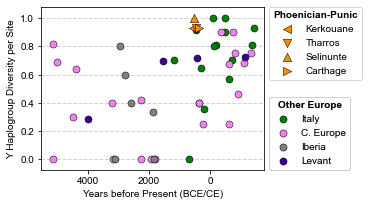

In [150]:
epsilon=0
s=50
m="o"
sf=1.4
lw = 0.5

plt.figure(figsize=(4,3))
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(axis='y', color='lightgray', linestyle='dashed', linewidth=1, zorder=0)

a1 = ax.scatter(df_y_it["age"]-1950, df_y_it["D"]+epsilon, c="green", ec="k", s=s, marker=m, lw=lw)
a2 = ax.scatter(df_y_fr["age"]-1950, df_y_fr["D"]+epsilon, c="violet", ec="k", s=s, marker=m, lw=lw)
a3 = ax.scatter(df_y_ib["age"]-1950, df_y_ib["D"]+epsilon, c="gray", ec="k", s=s, marker=m, lw=lw)
a4 = ax.scatter(df_y_lev["age"]-1950, df_y_lev["D"]+epsilon, c="#390099", ec="k", s=s, marker=m, lw=lw)

#ax.scatter(df_y_him["age"]-1950, df_y_him["D"]+epsilon, ec="k", c="orange", label="Himera")
ax.set_ylabel("Y Haplogroup Diversity per Site")
ax.set_xlabel("Years before Present (BCE/CE)")
ax.invert_xaxis()


p1 = ax.scatter(dfpk["age"]-1950, dfpk["D"]+epsilon, ec="k", c="darkorange", s=s*sf, marker="<", lw=lw)
p2 = ax.scatter(dfpt["age"]-1950, dfpt["D"]+epsilon, ec="k", c="darkorange", s=s*sf, marker="v", lw=lw)
p3 = ax.scatter(dfps["age"]-1950, dfps["D"]+epsilon, ec="k", c="darkorange", s=s*sf, marker="^", lw=lw)
p4 = ax.scatter(dfpc["age"]-1950, dfpc["D"]+epsilon, ec="k", c="darkorange", s=s*sf, marker=">", lw=lw)

#### Legend Punic
plots = [p1, p2, p3, p4]
legs = ["Kerkouane", "Tharros", "Selinunte", "Carthage" ]

leg1 = ax.legend(plots, legs, fontsize=10, 
                 title = "Phoenician-Punic",
                 bbox_to_anchor=(1.00, 1.03), loc="upper left")
#[lgd.set_edgecolor('white') for lgd in leg1.legendHandles]
leg1.get_title().set_fontsize('10')
leg1.get_title().set_fontweight("bold")
ax.add_artist(leg1)

### Legend Context Sites
plots = [a1, a2, a3, a4]
legs = ["Italy", "C. Europe", "Iberia", "Levant" ]

leg2 = ax.legend(plots, legs, fontsize=10, 
                 title = "Other Europe",
                 bbox_to_anchor=(1.00, -0.03), loc="lower left")
#[lgd.set_edgecolor('white') for lgd in leg1.legendHandles]
leg2.get_title().set_fontsize('10')
leg2.get_title().set_fontweight("bold")
ax.add_artist(leg2)


#set_legends(ax, plots=plots, legs=legs, title="Phoenician-Punic")
#ax.set_xticks(np.linspace(-5000,1000,7))
plt.show()

# Save the Y Haplogroup Diversity
Plot over in './browse_divpca.ipynb'

In [ ]:
ax.scatter(df_y_it["age"]-1950, df_y_it["D"]+epsilon, ec="gray", label="Italy")
ax.scatter(df_y_fr["age"]-1950, df_y_fr["D"]+epsilon, c="yellow", ec="gray", label="C. Europe")
ax.scatter(df_y_ib["age"]-1950, df_y_ib["D"]+epsilon, c="orange", ec="gray", label="Iberia")
ax.scatter(df_y_lev["age"]-1950, df_y_lev["D"]+epsilon, c="green", ec="gray", label="Levant")
ax.scatter(df_y_pun["age"]-1950, df_y_pun["D"]+epsilon, ec="k", c="red", label="Phoenician-Punic")

In [62]:
df_y_it.to_csv("./output/tables/ydiv/it.tsv", sep="\t", index=False)
df_y_fr.to_csv("./output/tables/ydiv/fr.tsv", sep="\t", index=False)
df_y_ib.to_csv("./output/tables/ydiv/ib.tsv", sep="\t", index=False)
df_y_lev.to_csv("./output/tables/ydiv/lev.tsv", sep="\t", index=False)
df_y_pun.to_csv("./output/tables/ydiv/pun.tsv", sep="\t", index=False)

# 1b Make Map of Punic Y Haplogroup Diversity 
Preperation work: Load all Punic Y Haplogroups

In [163]:
df_punic["Y_haplo"].str[:3].value_counts()

E1b    14
R1b    10
J2a     8
G2a     7
J1a     4
T1a     3
J2b     3
I2a     2
L       1
E1a     1
I       1
E1      1
C1a     1
J1      1
R1a     1
Name: Y_haplo, dtype: int64

In [173]:
df_punic[df_punic["Y_haplo"]=="I"]

,iid,Master ID,loc,lat,lon,age,region,study,clst,mean_cov,...,include,label_fine,location,label,clst_qpadm,cluster_geo,published,date range,direct date,SNPs
7,I22114,I22114,"Sardinia, Tharros",39.873496,8.441024,2239.0,Italy,Unpublished (Harald Ilan Punic),Italy_Sardinia_Punic_Late_oEurope,0.622697,...,1,Tharros_Late,Tharros,Punic_Late,PunicLateEu,Sardinia,NaN,"387-208 calBCE (2245Â±20 BP, PSUAMS-9222)",y,747236


# Area 51

In [ ]:
df_y_it.sort_values(by="age", ascending=False)

In [221]:
dft = df[df["loc"].str.contains("Perdasdefogu")].sort_values(by="age")[1:]

In [ ]:
df_y_ib = get_sub_df_region(["Jordania"])
df_y_ib

In [ ]:
df[df["loc"]=="Abruzzo, Alfedena"]